In [1]:
#installs 1/2
import os
import numpy as np

In [2]:
#installs 2/2
from keras import regularizers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Rescaling, Dropout, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from pandas import read_csv, merge
from PIL import Image
import matplotlib.pyplot as plt

2024-03-22 21:11:32.008830: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 21:11:32.012147: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 21:11:32.051642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 21:11:32.956877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#creating two dataframes from two mapping files: gz2_filename_mapping.csv and gz2_hart16.csv

labels_df = read_csv(os.path.join("galaxyZoo/gz2_hart16.csv")) #csv file containing the classification associated with each SDSS object
img_id_df = read_csv(os.path.join("galaxyZoo/gz2_filename_mapping.csv")) #csv file containing the SDSS object id associated with each image

In [4]:
#cleaning up  dataframes in preperation for merging

#fixing the classification dataframe
labels_df.rename(columns={'dr7objid': "specobjid"}, inplace=True) # we renamed the column "dr7objid" to "specobjid" so we can merge based on the similar column
relevant_columns = ['specobjid', 'gz2_class']  # here we decided what columns to remove

smaller_df = labels_df[relevant_columns].copy()  # here we removed all the other columns we aren't using from the classification dataframe
smaller_df = smaller_df.sort_values(by = "specobjid") #sort the values by the SDSS id from smallest to largest

smaller_df["specobjid"] = smaller_df["specobjid"].astype(int) #weirdly enough, the values in the SDSS id column were strings so we converted them to ints

#fixing the image id dataframe
img_id_df = img_id_df.dropna() #dropping any rows with NaN values
img_id_df = img_id_df.sort_values(by = "specobjid") #sort the values by the SDSS id from smallest to largest
#DELETE-> img_id_df = img_id_df.head(239695) 



In [5]:
#merging the two dataframes on the SDSS id column, which was already aligned
merge_df = merge(smaller_df, img_id_df, on = "specobjid", how = "inner")
print(merge_df)

#at this point there are 194952 possible images

                 specobjid gz2_class    sample  asset_id
0       587722981741363294        Sb  original         3
1       587722981741363323      Sc?l  original         4
2       587722981741428877  SBb3m(r)     extra    245612
3       587722981741559888        Er  original         5
4       587722981741625481      Sc1t  original         6
...                    ...       ...       ...       ...
239690  588848901537988759        Ei  original    245605
239691  588848901538447575        Ei  original    245606
239692  588848901538578615     SBb2m  original    245607
239693  588848901539430566        Ec  original    245608
239694  588848901539627254     SBc?m  original    245609

[239695 rows x 4 columns]


In [6]:
#creating the final dataframe, which has image id, SDSS id, and classification aligned correctly

img_name = os.listdir("galaxyZoo/images/") #list of every image in the directory

asset_id = []
for name in img_name: #going through each image and removing the suffix, so that it will eventually match the image id
    name = name.removesuffix(".jpg") #cool function that autopopulated instead of splicing
    name = int(name) 
    asset_id.append(name) #adding to a list
#there are 14060 images in the directory

#creates a mask 
    #if the value in the merged dataframes image id column is also in the directory the value will return as true and
    #be kept, otherwise it's dropped
mask = merge_df["asset_id"].isin(asset_id)
final_df = merge_df[mask]
final_df = final_df.sort_values(by = "asset_id") #sorts the values by image id from least to greatest
#there are 13965 possible images

#final_df.to_csv("please.csv") --> for saving the dataframe 

In [7]:
#we take all the classification values and one hot encode them for model fitting

spec_list = []
class_df = final_df["gz2_class"]
for n in class_df:
    spec_list.append(n)
spec_list = [s[:1] for s in spec_list] #cuts all the weird stuff from the classification
#batch because laptop doesn't have enough memory
spec_list = spec_list[:12000]

label_encoder = LabelEncoder() 
specs = label_encoder.fit_transform(spec_list) #one hot encodes the classification

In [8]:
#adds the images to an array
    #right now i cut it down to the first 4805 images because that's exactly how much ran before crashing
dir = os.listdir("galaxyZoo/images/")
dir.sort()
x = []
n = 0
h = 200
w = 200
top = 112
right = 112

while n < 12000: 
    for filename in dir:
        image = Image.open(f"galaxyZoo/images/{filename}")
        img_array = np.array(image)
        img_array = img_array[top: (top + h), right: (right + w)] #cropping the image to the center 200 by 200 pixels
        x.append(img_array)
        n +=1
        if n >= 12000:
            break
x = np.array(x)

In [9]:
#created the train and test

specs = to_categorical(specs) 
x_train, x_test, y_train, y_test = train_test_split(x, specs, test_size=0.5, random_state=42)

In [10]:
#defining the model
model = Sequential([
    Conv2D(16, kernel_size= (5,5), activation = "relu",input_shape = (200, 200, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size= (3,3), activation = "relu"),
    Rescaling(1./255),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),
    Conv2D(64, kernel_size= (3,3), activation = "relu"),
    MaxPooling2D(pool_size=(2, 2)),

    #all input should have a shape of 200 with 3 RGB channels
    Flatten(), 
    Dense(512, activation='relu', ),
    Dropout(0.25),
    Dense(3, activation='softmax'), #last layer has an ouptut of 10 because there's 10 categories
])
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-22 21:11:52.695532: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.
2024-03-22 21:11:52.737731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.
2024-03-22 21:11:52.742225: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 196, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    17,334,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,360,675 (66.23 MB)

 Trainable params: 17,360,675 (66.23 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#the model is fit and 15 epochs are run

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)
model.fit(
    x_train,
    y_train,
    epochs = 5, 
    validation_data = (x_test, y_test),
    batch_size = 10,
)

Epoch 1/5


2024-03-22 21:11:52.849826: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 720000000 exceeds 10% of free system memory.
2024-03-22 21:11:53.855336: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.


600/600 ━━━━━━━━━━━━━━━━━━━━ 184s 304ms/step - accuracy: 0.5705 - loss: 0.7393 - val_accuracy: 0.5682 - val_loss: 0.7030
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 156s 260ms/step - accuracy: 0.5945 - loss: 0.6938 - val_accuracy: 0.5682 - val_loss: 0.7218
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 157s 262ms/step - accuracy: 0.6028 - loss: 0.6945 - val_accuracy: 0.5682 - val_loss: 0.7087
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 192s 246ms/step - accuracy: 0.6044 - loss: 0.6948 - val_accuracy: 0.5682 - val_loss: 0.7012
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 215s 268ms/step - accuracy: 0.6010 - loss: 0.6869 - val_accuracy: 0.5682 - val_loss: 0.7059


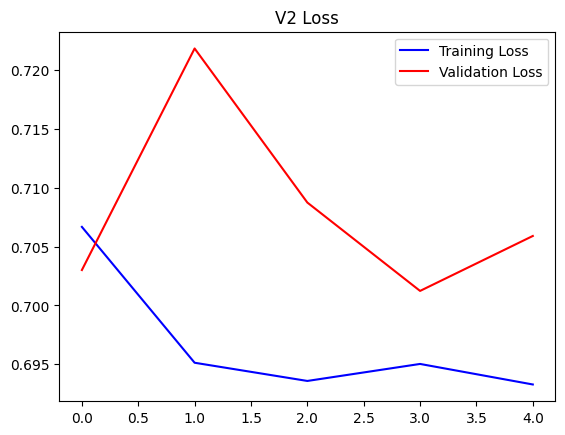

In [12]:
plt.plot(model.history.history['loss'],color='b', label='Training Loss',)
plt.plot(model.history.history['val_loss'],color='r',
label='Validation Loss')
plt.title("V2 Loss")
plt.legend()
plt.show()

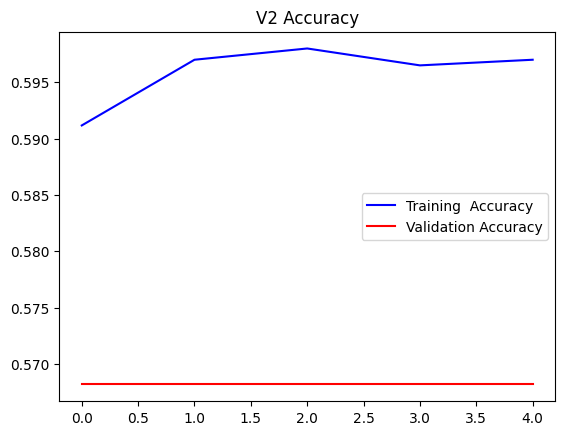

In [13]:
plt.plot(model.history.history['accuracy'],color='b',
label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',
label='Validation Accuracy')
plt.title("V2 Accuracy")
plt.legend()
plt.show()

In [14]:
#testing the model 
model.evaluate(x_test, y_test)

#with the last image, which wasn't included in the training or testing
    #there are 10 output columns in 115405
img = Image.open("galaxyZoo/images/11.jpg") #testing with the last image
img = np.array(img)
img = img[top: (top + h), right: (right + w)] #cropping the image to the center 200 by 200 pixels
img = np.reshape(img, (200, 200, 3))
# predict = model.predict(x_test)
# print(predict)
img = np.expand_dims(img, axis=0)
#calling model?
predict = model(img)
predict = predict.numpy()


188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.5630 - loss: 0.7076


In [15]:
a = predict.tolist()
a = a[0]


the_good_list = a.copy() 

the_good_list.sort(reverse = True)
print(a)
b = the_good_list[0]

max_index = a.index(b) 

print("the image is classified as: ", end = "")
match max_index:
    case 0:
        print("A")
    case 1:
        print("Ec")
    case 2:
        print("Ei")
    case 3:
        print("Er")
    case 4:
        print("SB")
    case 5:
        print("Sa")
    case 6:
        print("Sb")
    case 7:
        print("Sc")
    case 8:
        print("Sd")
    case 9:
        print("Se")


[0.00535292224958539, 0.3844686448574066, 0.6101784110069275]
the image is classified as: Ei


```Epoch 1/5
2024-03-22 20:07:41.775507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 720000000 exceeds 10% of free system memory.
2024-03-22 20:07:42.887494: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.
600/600 ━━━━━━━━━━━━━━━━━━━━ 177s 292ms/step - accuracy: 0.5618 - loss: 26.3501 - val_accuracy: 0.5685 - val_loss: 2.5794
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 165s 274ms/step - accuracy: 0.5975 - loss: 2.0642 - val_accuracy: 0.5682 - val_loss: 1.2622
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 213s 292ms/step - accuracy: 0.5920 - loss: 1.1415 - val_accuracy: 0.5682 - val_loss: 0.9152
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 167s 279ms/step - accuracy: 0.6064 - loss: 0.8828 - val_accuracy: 0.5682 - val_loss: 0.8050
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 200s 276ms/step - accuracy: 0.5968 - loss: 0.8111 - val_accuracy: 0.5678 - val_loss: 0.7741